In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
df = pd.read_csv('FPT.csv')
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [22]:
df.dtypes


,0
Ticker,object
Date/Time,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Open Interest,int64


Convert to DailyPrice Data

In [23]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])


df['Date'] = df['Date/Time'].dt.date
daily_data = df.groupby('Date').agg({
    'Open': 'first',   
    'Close': 'last',    
    'High': 'max',     
    'Low': 'min',      
    'Volume': 'sum'    
}).reset_index()
daily_data


,Date,Open,Close,High,Low,Volume
0,2018-12-25,30.89,30.66,30.89,30.59,84960
1,2018-12-26,31.04,30.89,31.22,30.89,333590
2,2018-12-27,31.41,31.19,31.52,31.19,454860
3,2018-12-28,31.34,31.49,31.49,31.19,387170
4,2019-01-02,31.19,30.74,31.45,30.70,459120
...,...,...,...,...,...,...
494,2020-12-16,57.20,57.10,57.50,57.00,1995530
495,2020-12-17,56.90,56.50,57.00,56.00,3594500
496,2020-12-18,56.50,56.90,57.00,56.50,1532820
497,2020-12-21,57.30,57.50,57.80,57.10,2307390


Text(0, 0.5, 'Open')

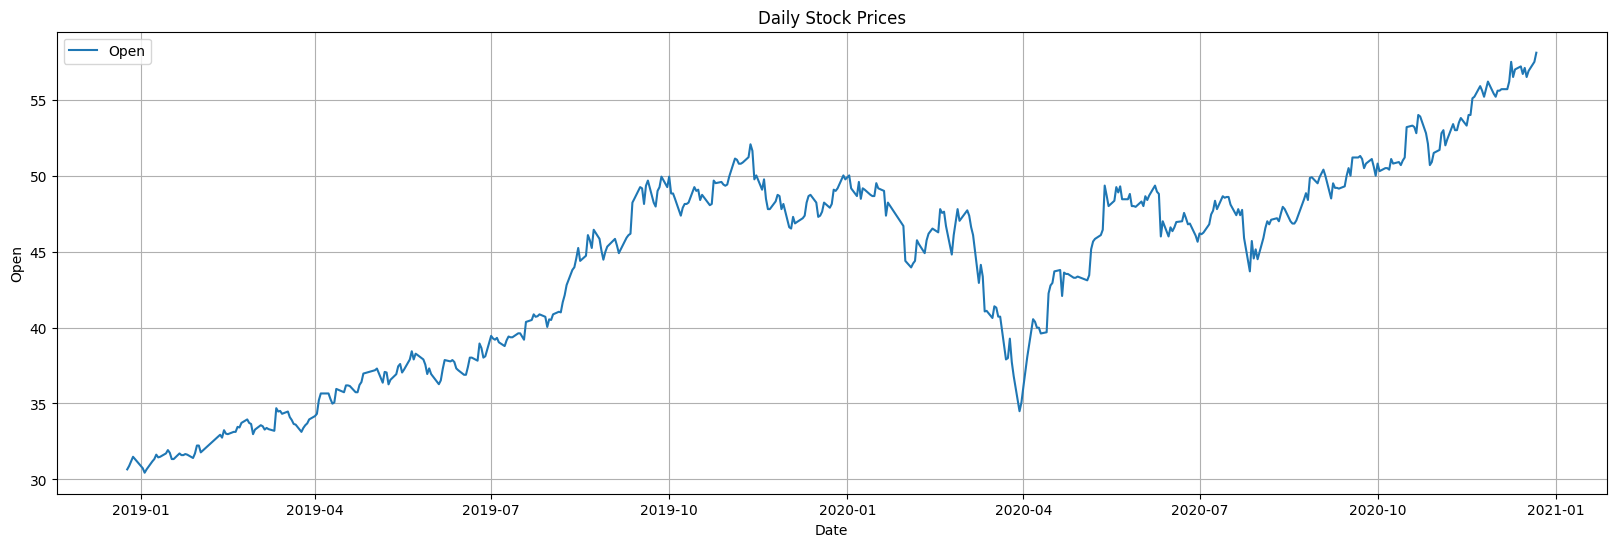

In [24]:
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date'], daily_data['Close'], label='Close')
plt.title('Daily Stock Prices')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close')

In [25]:
daily_data['Price Change']= daily_data['Close'] - daily_data['Close'].shift(+1)
daily_data.dropna(inplace=True)  # Drop the last row with NaN values
daily_data[['Date', 'Close', 'Price Change']]



,Date,Close,Price Change
1,2018-12-26,30.89,0.23
2,2018-12-27,31.19,0.30
3,2018-12-28,31.49,0.30
4,2019-01-02,30.74,-0.75
5,2019-01-03,30.44,-0.30
...,...,...,...
494,2020-12-16,57.10,0.40
495,2020-12-17,56.50,-0.60
496,2020-12-18,56.90,0.40
497,2020-12-21,57.50,0.60


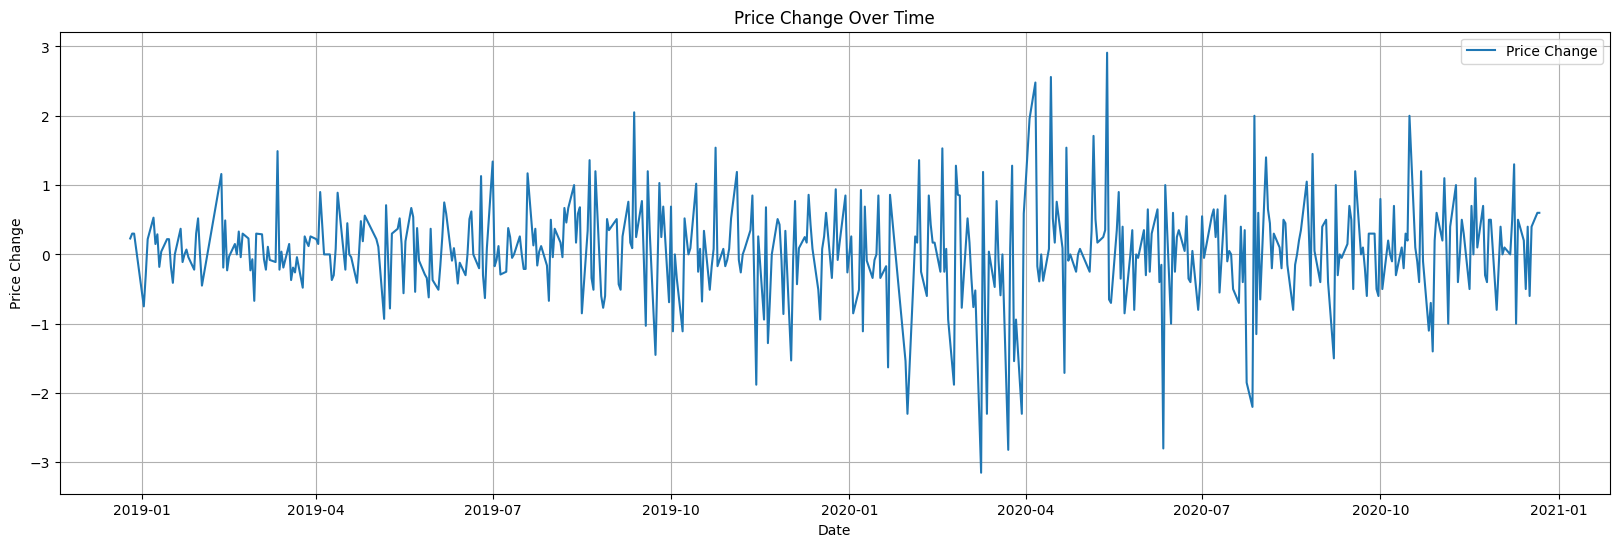

In [67]:
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date'], daily_data['Price Change'], label='Price Change')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Price Change Over Time')
plt.legend()
plt.grid(True)
plt.show()


Linear Regression and Raindom Forest

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [69]:
X = daily_data[['Open', 'High', 'Low', 'Volume', 'Close']]
y = daily_data['Price Change']

Split (80% for train and 20% for test)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
# Create Object for RFR
rf = RandomForestRegressor()

#Define the hyperparameter grid
param_grid = {
    'max_depth' : [3, 5, 7, 9], #Maximum depth of each decision tree (try 4 dif depth)
    'min_samples_split' : [2, 5, 10], #Minimum number of samples required to split
    'min_samples_leaf' : [1, 2, 4], #Minimum number of samples that must be present in a leaf node.
    'max_features' : ['auto', 'sqrt'], #Number of features to consider when looking for the best split (Auto for all feature, sqrt for square root of of the total for reducing overfitting)
    'random_state' : [0, 42] #Fixes the random seed
} #GridSearchCV will test 4 x 3 x 3 x 2 x 2 = 144 combinations of hyperparameters.

# Create a GridSearchCV Object
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'r2') #cv=5 to split training data to 5 folds, 4 for train and 1 for test, r2 for R square

#Fit the GridSearchCV object to training Data
grid_search.fit(X_train, y_train)

#Print the best hypeparameters
print(grid_search.best_params_)

best_params = grid_search.best_params_


{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Initialize models

In [72]:
rf = RandomForestRegressor(**best_params)
linear_model = LinearRegression()


Train the models


In [73]:
linear_model.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=2,
                      random_state=0)

Predict by RandomForest and Linear Regression

In [74]:
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'Mean Squared Error (Linear Regression): {mse_linear}')
print(f'Mean Squared Error (Random Forest): {mse_rf}')


Mean Squared Error (Linear Regression): 0.10264722329459637
Mean Squared Error (Random Forest): 0.35428857307897255


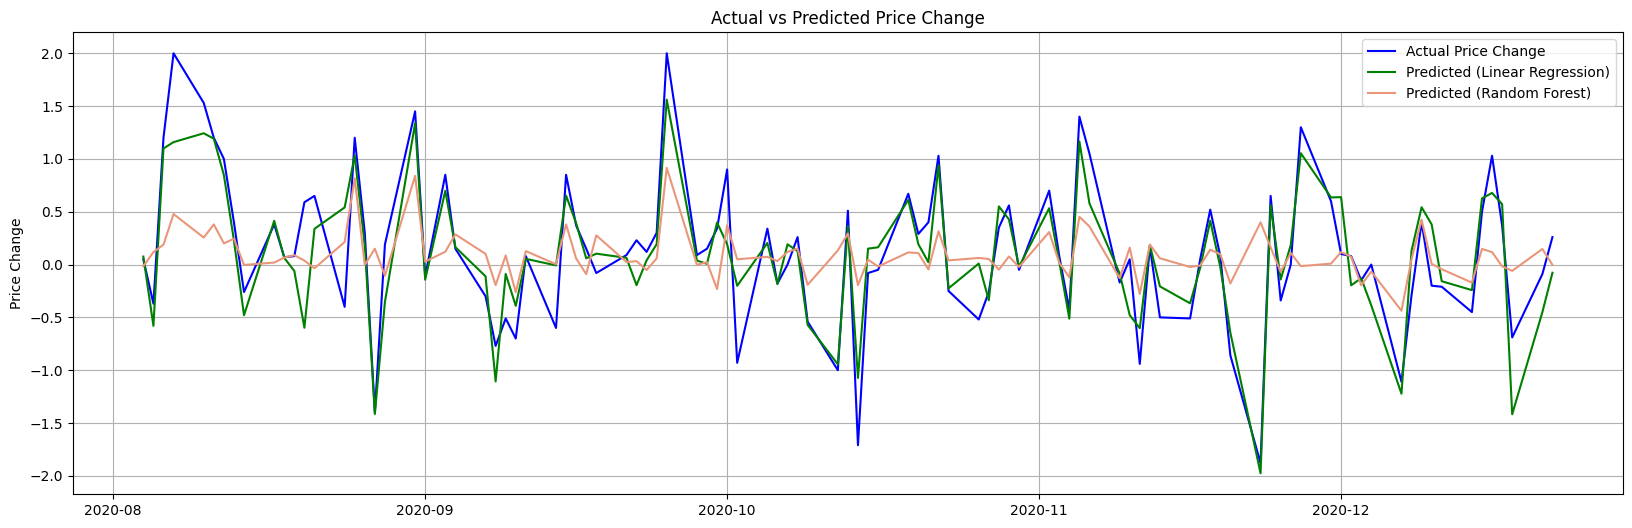

In [75]:
plt.figure(figsize=(20, 6))
test_dates = daily_data['Date'][len(daily_data) - len(y_test):]
plt.plot(test_dates, y_test, label='Actual Price Change', color='blue')
plt.plot(test_dates, y_pred_linear, label='Predicted (Linear Regression)', color='green')
plt.plot(test_dates, y_pred_rf, label='Predicted (Random Forest)', color='darksalmon')



plt.title('Actual vs Predicted Price Change')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.show()

LSTM


In [76]:
from sklearn.preprocessing import MinMaxScaler #use for scaling and normalizing data

#Normalize
scaler = MinMaxScaler() #initilaize object
price_change_scaler = MinMaxScaler()

# Select only numeric features for scaling
numeric_features = daily_data.select_dtypes(include=['number']).columns
daily_data_scaled = scaler.fit_transform(daily_data[numeric_features]) #fit the scaler by calculating min and max value, then transform to 0 1

# Fit the price_change_scaler to the 'Price Change' column
price_change_scaler.fit(daily_data[['Price Change']])

#Split the data into training and testing set
train_size = int(len(daily_data_scaled) * 0.8) #len for counting total number in row, 0.8 for 80% use for train
train_data, test_data = daily_data_scaled[:train_size], daily_data_scaled[train_size:]

In [77]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range (len(data) - sequence_length ):
        x.append(data[i:(i+ sequence_length), 0]) # Collect sequence of length
        y.append(data[i + sequence_length, 0]) # Collect the next value as the target
    return np.array(x), np.array(y) #Converts the list of input sequences and target value into a NumPy array.

sequence_length = 10 #each input sequence contain 20 time steps
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


# Reshape to (samples, sequence_length, features) for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [78]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    # Define the input shape using Input layer
    inputs = Input(shape=(X_train.shape[1], 1))

    # First LSTM layer (no need to specify input_shape here)
    x = LSTM(units=units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)

    # Second LSTM layer
    x = LSTM(units=units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)

    # Third LSTM layer
    x = LSTM(units=units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)

    # Dense Layer
    x = Dense(units=units)(x)
    x = Dropout(dropout_rate)(x)

    # Output Layer
    outputs = Dense(units=1)(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Create a KerasRegressor wrapper for the LSTM model
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.3, 0.4],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

# Get the best model and its parameters
best_params = grid.best_params_
best_params = {k.replace('model__', ''): v for k, v in best_params.items()}
best_model = create_model(**best_params)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Fit the model with the best parameters
best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Best Hyperparameters: {'dropout_rate': 0.3, 'units': 100}
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 0.1773 - val_loss: 0.0072
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0351 - val_loss: 0.0203
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0209 - val_loss: 0.0281
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0198 - val_loss: 0.0057
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0154 - val_loss: 0.0094
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0102 - val_loss: 0.0125
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0111 - val_loss: 0.0078
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 12/100
5/

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error: 0.002026719266657318


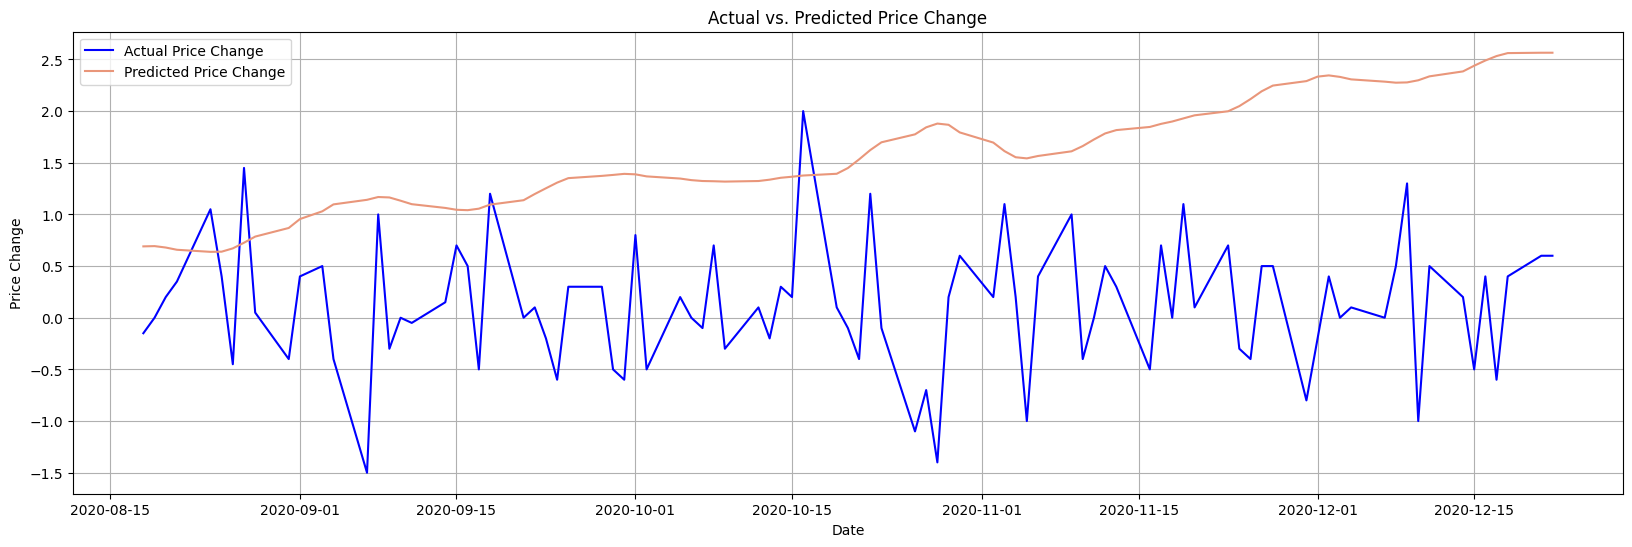

In [82]:
predictions = best_model.predict(X_test)


from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


predictions_original_scale = price_change_scaler.inverse_transform(predictions.reshape(-1, 1))  # Reshape for inverse_transform
predictions_original_scale = predictions_original_scale.flatten()  # Flatten back to 1D

test_dates_adjusted = daily_data['Date'][train_size + sequence_length : train_size + sequence_length + len(predictions)]

plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date'][train_size + sequence_length:], daily_data['Price Change'][train_size + sequence_length:], label='Actual Price Change', color='blue')  # Use original 'Price Change' for actual values
plt.plot(test_dates_adjusted, predictions_original_scale, label='Predicted Price Change', color='darksalmon')  # Use inverse-transformed predictions with adjusted dates
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Actual vs. Predicted Price Change')
plt.legend()
plt.grid(True)
plt.show()


ARIMA MODEL


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=893.757, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=886.343, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=887.771, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=887.766, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=889.763, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=887.262, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.825 seconds
Mean Squared Error (ARIMA): 0.36882395573305926


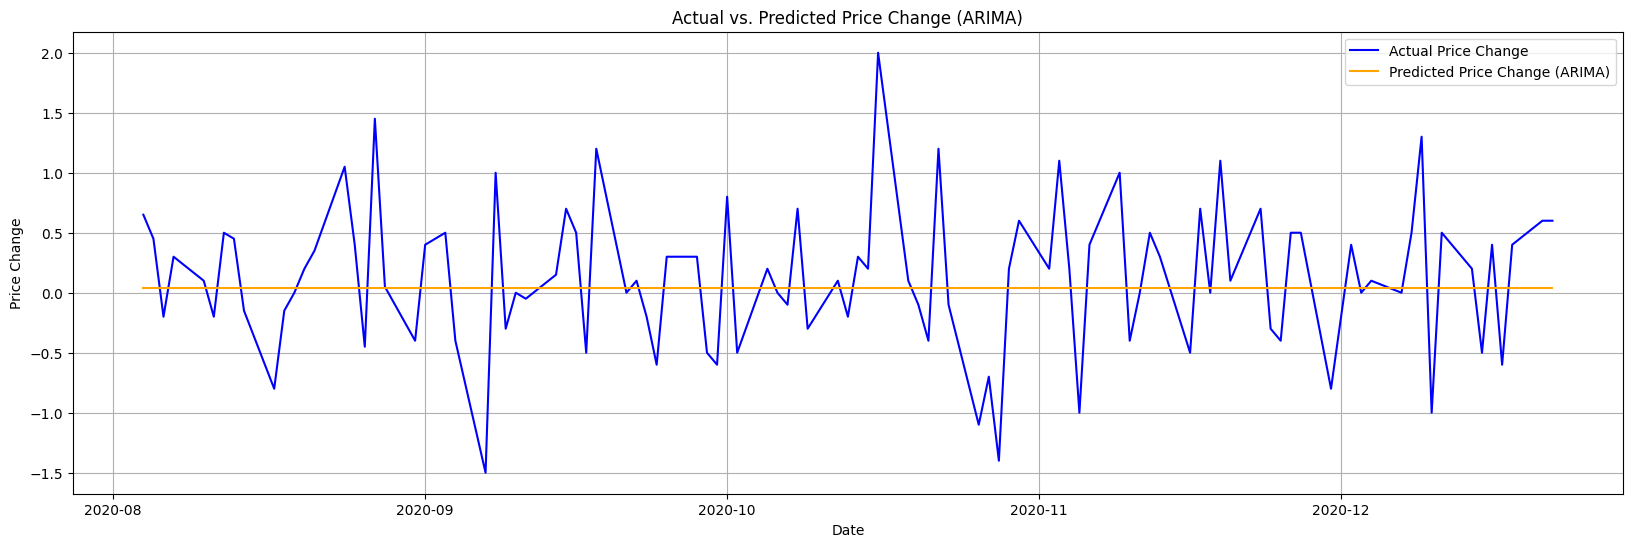

In [64]:
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm

best_model_arima = pm.auto_arima(y_train, seasonal=False,
                                stepwise=True, suppress_warnings=True,
                                error_action="ignore", trace=True)
p,d,q = best_model_arima.order

# Prepare the data for ARIMA
y = daily_data['Price Change'].values
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

# Fit the ARIMA model
model_arima = ARIMA(y_train, order=(p, d, q))
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) -1 )

# Evaluate the model
mse_arima = mean_squared_error(y_test, predictions_arima)
print(f'Mean Squared Error (ARIMA): {mse_arima}')

# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date'][train_size:], y_test, label='Actual Price Change', color='blue')
plt.plot(daily_data['Date'][train_size:], predictions_arima, label='Predicted Price Change (ARIMA)', color='orange')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Actual vs. Predicted Price Change (ARIMA)')
plt.legend()
plt.grid(True)
plt.show()
